Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002).
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.


**Implementation**

While we inserted code cells to indicate where you should implement your own code, please feel free to add/remove code blocks where you see fit (but make sure that the general structure of the assignment is preserved). Also, please keep in mind that it is always good practice to structure your code properly, e.g., by implementing separate classes and functions that can be reused.

## Environment

All code should be written in **Python 3**.
This is the default in Google Colab.

In [1]:
!python --version

Python 3.11.5


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download).
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects.


**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [2]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
#from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import scipy.sparse as sp
import warnings

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [4]:
# download sentiment lexicon
#!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
#!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [5]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list}
#  {"cv": integer, "sentiment": str, "content": list}
#   ..
# ]
# where `content` is a list of sentences,
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)

print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4:
    break

c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1

print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))


Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

# (1) Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [6]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 4:
      break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [7]:
# YOUR CODE HERE
def count_pos_vs_neg(content, lexicon, strong_weight=1):
  """
  Counts the number of positive and negative words in content and returns the
  weighted difference between them (negative value means more negative words).

  Parameters:
  -----------
  content: list
    A list of sentences forming the content of a review. Each sentence is a
    list whose elements are (token, PoS tag) pairs.

  lexicon: dict
    A dictionary mapping tokens to (magnitude, sentiment) pairs.

  strong_weight: int, optional
    How strongly tokens with strong magnitude are weighted relative to tokens
    with weak magnitude. A value of 1 discards magnitude information.
    default 1.

  Returns:
  --------
  score: int
    The difference between the number of positive and negative words, with
    strong words weighted according to strong_weight.
  """
  score = 0
  for sentence in content:
    for token, _ in sentence:
      type_, polarity = lexicon.get(token.lower(), (None, None))
      sign = 0
      weight = strong_weight if type_ == 'strongsubj' else 1
      if polarity == 'positive':
        sign = 1
      elif polarity == 'negative':
        sign = -1
      score += sign * weight
  return score

def lexicon_classify(reviews, lexicon, threshold=8, strong_weight=1):
  """
  For a given review, predict the sentiment based on the number of positive and
  negative words in the review.

  Parameters:
  -----------
  reviews: list
    A list of reviews, where each review is a dictionary containing at least the
    key "content". The value of "content" is a list of sentences forming the
    content of a review. Each sentence is a list whose elements are
    (token, PoS tag) pairs.

  lexicon: dict
    A dictionary mapping tokens to (magnitude, sentiment) pairs.

  threshold: int, optional
    If the number of positive words minus the number of negative words is above
    the threshold, the review is predicted to be positive. Otherwise, the review
    is predicted to be negative.
    default: 8.

  strong_weight: int, optional
    How strongly tokens with strong magnitude are weighted relative to tokens
    with weak magnitude. A value of 1 discards magnitude information.
    default: 1.

  Returns:
  --------
  predictions: array
    An array of predicted sentiment scores, where 1 is positive and 0 is negative.
  """
  predictions = []
  i=0
  for r in reviews:
    i += 1
    score = count_pos_vs_neg(r['content'], lexicon, strong_weight) # Count words
    if score > threshold: # Add prediction
      predictions.append(1)
    else:
      predictions.append(0)
  return np.array(predictions)

In [8]:
# Create dictionary of sentiment lexicon
sentiment_lexicon = dict() # {word1: (type, priorpolarity)}
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  for line in f:
    entry = [item.split('=')[1] for item in line.split()]
    token = entry[2].lower()
    if token in sentiment_lexicon:
      # If token is already konwn with different sentiment, make sentiment 'both'
      if entry[5] != sentiment_lexicon[token][1]:
        sentiment_lexicon[token] = (entry[0], 'both')
    else: # Add new token
      sentiment_lexicon[token] = (entry[0], entry[5])

# Get predictions and ground truths
token_predictions = lexicon_classify(reviews, sentiment_lexicon, 8, 1)
ground_truths = np.array([1 if r['sentiment'] == 'POS' else 0 for r in reviews])

In [9]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...]
# where 1 indicates a correct classification and 0 an incorrect classification.
token_results = token_predictions == ground_truths
token_accuracy = np.mean(token_results)
print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 0.68


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [10]:
# YOUR CODE HERE
# Sanity check: compute average difference between positive and negative words without
# magnitude information.
score = 0
for r in reviews:
  score += count_pos_vs_neg(r['content'], sentiment_lexicon, 1)
print(f'Bias without magnitude information: {score / len(reviews):.2f}')

# Compute average difference between positive and negative words with magnitude information.
score = 0
for r in reviews:
  score += count_pos_vs_neg(r['content'], sentiment_lexicon, 2)
print(f'Bias with magnitude information: {score / len(reviews):.2f}')

Bias without magnitude information: 6.82
Bias with magnitude information: 11.20


In [11]:
# Get predictions. Threshold chosen based on results above.
magnitude_predictions = lexicon_classify(reviews, sentiment_lexicon, 12, 2)

In [12]:
magnitude_results = magnitude_predictions == ground_truths
magnitude_accuracy = np.mean(magnitude_results)
print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 0.69


#### (Q.1.3) Make a barplot of the two results (0.5pt)

[]

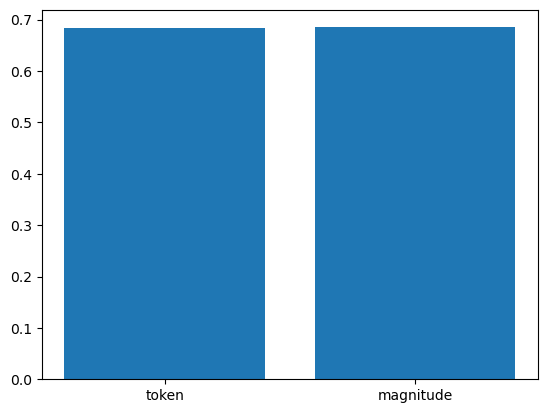

In [14]:
# YOUR CODE HERE
plt.bar(['token', 'magnitude'], [token_accuracy, magnitude_accuracy])
plt.plot()

#### (Q1.4) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

*Answer*

Longer reviews will on average have more positive or negative words, and will therefore contribute more to the average number of positive and negative words than shorter reviews. Hence the fact that there are more positive than negative words per review does not necessarily mean that reviews with slightly more positive than negative words are mostly negative reviews. It might also be because positive reviews are longer than negative reviews on average, and thus contribute more to the difference between the number of positive and negative words. As a result, short positive reviews might not reach the threshold and be classified as negative.

As an alternative, we can compute the median difference between the number of possitive and negative words. This will make sure that longer reviews don't count more than shorter ones.

In [15]:
# YOUR CODE HERE
# We find the median difference instead of the mean difference

def median(l):
  """Finds median value in an (unsorted) list of numbers."""
  l = sorted(l)
  if len(l) % 2 == 1:
    return l[len(l) // 2]
  return (l[len(l) // 2 - 1] + l[len(l) // 2]) / 2

# Find median difference without magnitude information
differences = []
for r in reviews:
  difference = count_pos_vs_neg(r['content'], sentiment_lexicon, 1)
  differences.append(difference)
token_median = median(differences)
print("Median difference without magnitude information :", token_median)

# Find median difference with magnitude information
differences = []
for r in reviews:
  difference = count_pos_vs_neg(r['content'], sentiment_lexicon, 2)
  differences.append(difference)
magnitude_median = median(differences)
print("Median difference with magnitude information :", magnitude_median)

Median difference without magnitude information : 6.0
Median difference with magnitude information : 9.0


In [16]:
# Test with new thresholds
token_predictions = lexicon_classify(reviews, sentiment_lexicon, 6, 1)
token_results = token_predictions == ground_truths
token_accuracy = np.mean(token_results)
print("Accuracy without magnitude information: %0.2f" % token_accuracy)

magnitude_predictions = lexicon_classify(reviews, sentiment_lexicon, 9, 2)
magnitude_results = magnitude_predictions == ground_truths
magnitude_accuracy = np.mean(magnitude_results)
print("Accuracy with magnitude information: %0.2f" % magnitude_accuracy)

Accuracy without magnitude information: 0.67
Accuracy with magnitude information: 0.68


# (2) Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes at test time**.  What would be the problem instead with skipping words only for one class in case 2?

*Answer*

Say that some word appears in class 1 but does not appear in class 2 in the training data. If we were to skip it at test time for class 2, but not skip it for class 1, this would disadvantage class 1. This is because the likelihood for class 1 would be multiplied with an extra probability, making it smaller, while the likelihood for class 2 would be unchanged. This means that class 1 would become less likely than class 2, because the document has a word that only appeared in class 1. This is clearly undesirable.

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [17]:
# YOUR CODE HERE
class NaiveBayesClassifier():
  '''
  Creates a Naive Bayes classifier. Contains a fit and predict method.
  When fitting, the classifier counts the number of documents and tokens in each class.
  When predicting, the classifier predicts the class with the highest posterior probability.
  '''
  def __init__(self):
    '''
    Initialize the classifier.
    '''
    self.doc_counter = Counter() # Counts how often each class occurs
    # Counts how often each token occurs per class
    self.token_counter = {'POS': Counter(), 'NEG': Counter()}
    self.total_tokens = dict() # The total number of tokens per class

  def fit(self, reviews):
    '''
    Fit the classifier to the given reviews.

    Parameters:
    -----------
    reviews: list
      A list of reviews, where each review is a dictionary with keys "cv",
      "sentiment", and "content". The value of "content" is a list of sentences
      forming the content of a review. Each sentence is a list of tokens.
    '''
    for r in reviews:
      self.doc_counter[r['sentiment']] += 1 # Count document
      for sentence in r['content']:
        for token in sentence:
          self.token_counter[r['sentiment']][token] += 1 # Count token
    # Total number of token occurences per class
    self.total_tokens['POS'] = self.token_counter['POS'].total()
    self.total_tokens['NEG'] = self.token_counter['NEG'].total()

  def predict(self, content):
    '''
    Predict the sentiment of the given content.

    Parameters:
    -----------
    content: list
      A list of sentences, where each sentence list of tokens.

    Returns:
    --------
    prediction: int
      A predicted sentiment, "POS" or "NEG".
    '''
    # Prior probabilities of each class
    p_pos = self.doc_counter['POS'] / self.doc_counter.total()
    p_neg = self.doc_counter['NEG'] / self.doc_counter.total()
    # Log posteriors per class
    pos_posterior = np.log(p_pos)
    neg_posterior = np.log(p_neg)
    for sentence in content:
      for token in sentence:
        # Only include tokens that were seen for both classes during training
        if token in self.token_counter['POS'] and token in self.token_counter['NEG']:
          # Update log posteriors
          pos_posterior += np.log(self.token_counter['POS'][token] / self.total_tokens['POS'])
          neg_posterior += np.log(self.token_counter['NEG'][token] / self.total_tokens['NEG'])
    if pos_posterior > neg_posterior:
      return 'POS'
    return 'NEG'

# Create dataset with lowered tokens without POS tags
reviews_no_pos = deepcopy(reviews)
for r in reviews_no_pos:
  for i, sentence in enumerate(r['content']):
    # Lower tokens, remove POS tags
    sentence_no_pos = [token.lower() for token, _ in sentence]
    r['content'][i] = sentence_no_pos

# Train and test Naive Bayes classifier
NB_classifier = NaiveBayesClassifier()
NB_classifier.fit(reviews_no_pos[:900] + reviews_no_pos[1000:1900])
test_reviews = reviews_no_pos[900:1000] + reviews_no_pos[1900:]
NB_results = [NB_classifier.predict(r['content']) ==
                                  r['sentiment'] for r in test_reviews]
NB_accuracy = sum(NB_results) / len(NB_results)
print("Naive Bayes accuracy: %0.3f" % NB_accuracy)

Naive Bayes accuracy: 0.825


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

*Answer*

No, accuracy would not be a good evaluation measure in that scenario. A classifier that classifies all data points as positive would get 90% accuracy, giving the impression that it works well, while it is actually useless.

Simulating this situation resulted in a drastically lower accuracy of 60%. The model probably had too few negative examples to learn how to properly differentiate between the two classes. Also, the vocabulary of the negative training reviews must be very small. As only tokens that occur in both classes are used for prediction, this means it skips a lot of relevant words, making predictions worse.

In [18]:
# YOUR CODE HERE
NB_classifier = NaiveBayesClassifier()
NB_classifier.fit(reviews_no_pos[:90] + reviews_no_pos[1000:1900])
test_reviews = reviews_no_pos[900:910] + reviews_no_pos[1900:]
NB_results = [NB_classifier.predict(r['content']) ==
                                  r['sentiment'] for r in test_reviews]
NB_accuracy = sum(NB_results) / len(NB_results)
print("Naive Bayes accuracy: %0.3f" % NB_accuracy)

Naive Bayes accuracy: 0.600


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction

$$ \frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ 
for a word $w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the accuracy.
Use $\kappa = 1$.

In [19]:
# YOUR CODE HERE
class NaiveBayesClassifier():
  '''
  Creates a Naive Bayes classifier with Laplace smoothing. Contains a fit and predict method.
  When fitting, the classifier counts the number of documents and tokens in each class.
  When predicting, the classifier predicts the class with the highest posterior probability.
  '''
  def __init__(self, k=1):
    '''
    Initialize the classifier.

    Parameters:
    -----------
    k: int, optional
      The smoothing parameter.
      default: 1
    '''
    self.doc_counter = Counter() # Counts how often each class occurs
    # Counts how often each token occurs per class
    self.token_counter = {'POS': Counter(), 'NEG': Counter()}
    self.total_tokens = dict() # The total number of tokens per class
    self.k = k # Smoothing constant

  def __class__(self):
    return NaiveBayesClassifier(self.k)

  def fit(self, reviews):
    '''
    Fit the classifier to the given reviews.

    Parameters:
    -----------
    reviews: list
      A list of reviews, where each review is a dictionary with keys "cv",
      "sentiment", and "content". The value of "content" is a list of sentences
      forming the content of a review. Each sentence is a list of tokens.
    '''
    for r in reviews:
      self.doc_counter[r['sentiment']] += 1 # Count document
      for sentence in r['content']:
        for token in sentence:
          self.token_counter[r['sentiment']][token] += 1 # Count token
    # Total number of token per class + vocabulary size per class * smoothing constant
    self.total_tokens['POS'] = self.token_counter['POS'].total() + len(self.token_counter['POS']) * self.k
    self.total_tokens['NEG'] = self.token_counter['NEG'].total() + len(self.token_counter['NEG']) * self.k

  def predict(self, content):
    '''
    Predict the sentiment of the given content.

    Parameters:
    -----------
    content: list
      A list of sentences, where each sentence list of tokens.

    Returns:
    --------
    prediction: int
      A predicted sentiment, "POS" or "NEG".
    '''
    # Prior probabilities of each class
    p_pos = self.doc_counter['POS'] / self.doc_counter.total()
    p_neg = self.doc_counter['NEG'] / self.doc_counter.total()
    # Log posteriors per class
    pos_posterior = np.log(p_pos)
    neg_posterior = np.log(p_neg)
    for sentence in content:
      for token in sentence:
        # Only include tokens that were seen for at least one class during training
        if token in self.token_counter['POS'] or token in self.token_counter['NEG']:
          # Update log posteriors using smoothing constant
          # (demoninator already includes smoothing term)
          pos_posterior += np.log((self.token_counter['POS'][token] + self.k) / self.total_tokens['POS'])
          neg_posterior += np.log((self.token_counter['NEG'][token] + self.k) / self.total_tokens['NEG'])
    if pos_posterior > neg_posterior:
      return 'POS'
    return 'NEG'

# Train and test smoothed Naive Bayes classifier
NB_classifier = NaiveBayesClassifier()
NB_classifier.fit(reviews_no_pos[:900] + reviews_no_pos[1000:1900])
test_reviews = reviews_no_pos[900:1000] + reviews_no_pos[1900:]
NB_results = [NB_classifier.predict(r['content']) ==
                                  r['sentiment'] for r in test_reviews]
NB_accuracy = sum(NB_results) / len(NB_results)
print("Naive Bayes accuracy: %0.3f" % NB_accuracy)

Naive Bayes accuracy: 0.830


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [20]:
# YOUR CODE HERE
def kfold_NB(classifier, reviews, k=10):
  '''
  Perform k-fold cross-validation on the given classifier.

  Parameters:
  -----------
  classifier: object
    The classifier to be evaluated.

  reviews: list
    A list of reviews, where each review is a dictionary with keys "cv",
    "sentiment", and "content". The value of "content" is a list of sentences
    forming the content of a review. Each sentence is a list of tokens.

  k: int, optional
    The number of folds.
    default: 10

  Returns:
  --------
  accuracies: list
    A list of accuracies for each fold.

  average_accuracy: float
    The average accuracy over all folds.
  '''
  accuracies = []
  indices = np.arange(len(reviews))

  # Perform k-fold cross-validation
  for i in range(k):
    classifier = classifier.__class__() # Reset classifier
    test_indices = indices[i::k] # Round-robin selection
    train_indices = np.delete(indices, test_indices)
    train_reviews = [reviews[i] for i in train_indices]
    test_reviews = [reviews[i] for i in test_indices]

    classifier.fit(train_reviews)
    results = [classifier.predict(r['content']) == r['sentiment'] for r in test_reviews]

    accuracy = sum(results) / len(results)
    accuracies.append(accuracy)
    print(f'Fold {i+1} accuracy: {accuracy:.3f}')

  average_accuracy = np.mean(accuracies)
  print(f'Average accuracy: {average_accuracy:.3f}')
  return accuracies, average_accuracy

In [21]:
accuracies, average_accuracy = kfold_NB(NaiveBayesClassifier(), reviews_no_pos)

Fold 1 accuracy: 0.775
Fold 2 accuracy: 0.835
Fold 3 accuracy: 0.815
Fold 4 accuracy: 0.830
Fold 5 accuracy: 0.775
Fold 6 accuracy: 0.845
Fold 7 accuracy: 0.820
Fold 8 accuracy: 0.775
Fold 9 accuracy: 0.820
Fold 10 accuracy: 0.830
Average accuracy: 0.812


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).** Note: you're not allowed to use a library for computing the variance.

In [22]:
# YOUR CODE HERE
variance = sum((accuracies - average_accuracy)**2) / len(accuracies)
print(f'Variance: {variance:.6f}')

Variance: 0.000651


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [23]:
# YOUR CODE HERE
def stem_reviews(rev, includes_pos=False):
  '''
  Stem the tokens in the given reviews in-place.

  Parameters:
  -----------
  rev: list
    A list of reviews, where each review is a dictionary with keys "cv",
    "sentiment", and "content". The value of "content" is a list of sentences
    forming the content of a review. Each sentence is a list of features.

  include_pos: bool
    If set to true, the input includes PoS tag features.
    default: False

  Returns:
  --------
  rev: list
    The stemmed reviews.
  '''
  porter_stemmer = PorterStemmer()
  for r in rev:
    for sentence in r['content']:
      for i, feature in enumerate(sentence):
        if includes_pos:
          sentence[i] = (porter_stemmer.stem(feature[0]), feature[1])
        else:
          sentence[i] = porter_stemmer.stem(feature)
  return rev

In [24]:
reviews_stemmed = deepcopy(reviews_no_pos) # Make a copy of the reviews
reviews_stemmed = stem_reviews(reviews_stemmed)

#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier.


In [25]:
# YOUR ANSWER HERE
accuracies, average_accuracy = kfold_NB(NaiveBayesClassifier(), reviews_stemmed)

Fold 1 accuracy: 0.785
Fold 2 accuracy: 0.835
Fold 3 accuracy: 0.800
Fold 4 accuracy: 0.845
Fold 5 accuracy: 0.775
Fold 6 accuracy: 0.835
Fold 7 accuracy: 0.810
Fold 8 accuracy: 0.760
Fold 9 accuracy: 0.835
Fold 10 accuracy: 0.830
Average accuracy: 0.811


#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [26]:
def get_vocab_counts(classifier):
  """
  Return the sizes of the learned vocabularies.

  Parameters:
  -----------
  classifier: NaiveBayesClassifier
    A trained Naive Bayes classifier.

  Returns:
  --------
  vocab_counts: (int, int, int)
    sizes of full vocabulary, positive vocabulary, and negative vocabulary.
  """
  vocab = Counter()
  vocab.update(classifier.token_counter['POS'])
  vocab.update(classifier.token_counter['NEG'])
  return len(vocab), len(classifier.token_counter['POS']), len(classifier.token_counter['NEG'])

In [27]:
# YOUR CODE HERE
train_set = reviews_no_pos[:900] + reviews_no_pos[1000:1900]

NB_classifier = NaiveBayesClassifier()
NB_classifier.fit(train_set)
counts1 = get_vocab_counts(NB_classifier)

print(f'Without stemming: {counts1[0]} total features, {counts1[1]} positive features, {counts1[2]} negative features')

train_set = reviews_stemmed[:900] + reviews_stemmed[1000:1900]

NB_classifier = NaiveBayesClassifier()
NB_classifier.fit(train_set)
counts2 = get_vocab_counts(NB_classifier)

print(f'Without stemming: {counts2[0]} total features, {counts2[1]} positive features, {counts2[2]} negative features')
print(f"Ratio of total features without stemming to total features with stemming: {counts1[0] / counts2[0]:.2f}")

Without stemming: 45348 total features, 33105 positive features, 31042 negative features
Without stemming: 32404 total features, 23501 positive features, 22229 negative features
Ratio of total features without stemming to total features with stemming: 1.40


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features.






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [28]:
# YOUR CODE HERE
def ngram_reviews(rev, n):
  """
  Creates n-grams features in-place for the reviews.

  Parameters:
  -----------
  rev: list
    A list of reviews, where each review is a dictionary with keys "cv",
    "sentiment", and "content". The value of "content" is a list of sentences
    forming the content of a review. Each sentence is a list of tokens.

  n: int
    Highest number of n-grams to be included. For example, n=3 will give
    unigrams, bigrams and trigrams as features.

  Returns:
  --------
  rev: list
    The reviews with n-grams.
  """
  for r in rev:
    for i, sentence in enumerate(r['content']):
      m = 2
      sentence_ngrams = sentence.copy()
      while m <= n:
        sentence_ngrams += list(ngrams(sentence, m))
        m += 1
      r['content'][i] = sentence_ngrams
  return rev

reviews_bigrams = deepcopy(reviews_stemmed)
reviews_bigrams = ngram_reviews(reviews_bigrams, 2)

reviews_trigrams = deepcopy(reviews_stemmed)
reviews_trigrams = ngram_reviews(reviews_trigrams, 3)

In [29]:
print('Unigram+bigram accuracies')
_ = kfold_NB(NaiveBayesClassifier(), reviews_bigrams)

print('\nUnigram+bigram+trigram accuracies')
_ = kfold_NB(NaiveBayesClassifier(), reviews_trigrams)

Unigram+bigram accuracies
Fold 1 accuracy: 0.790
Fold 2 accuracy: 0.830
Fold 3 accuracy: 0.815
Fold 4 accuracy: 0.880
Fold 5 accuracy: 0.775
Fold 6 accuracy: 0.875
Fold 7 accuracy: 0.825
Fold 8 accuracy: 0.825
Fold 9 accuracy: 0.875
Fold 10 accuracy: 0.845
Average accuracy: 0.834

Unigram+bigram+trigram accuracies
Fold 1 accuracy: 0.805
Fold 2 accuracy: 0.845
Fold 3 accuracy: 0.835
Fold 4 accuracy: 0.865
Fold 5 accuracy: 0.755
Fold 6 accuracy: 0.880
Fold 7 accuracy: 0.840
Fold 8 accuracy: 0.830
Fold 9 accuracy: 0.855
Fold 10 accuracy: 0.830
Average accuracy: 0.834



#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


*Answer*

The number of features in a Bag-of-Words (BoW) model with n-grams would be the sum of the number of unigrams, bigrams, trigrams, etc., up to n-grams we decide to include. In theory, the number of n-grams would be:

- For Unigrams: $∣V∣$ (where V is the vocabulary)
- For Bigrams: $∣V∣\times|V|$
- For Trigrams: $∣V∣\times∣V∣\times∣V∣$
- For n-grams: $∣V∣^n$ (where $n$ is the size of n-grams we decide to include)

This would be a polynomial increase in $|V|$ but an exponential increase in $n$. For example, if we were to use unigrams, bigrams and trigrams, the number of features would in theory be $∣V∣ + ∣V∣^2 + ∣V∣^3$. In practice however, the number of features is much lower than this, because many bigrams and trigrams do not occur in the data. The reason behind this is that the number of possible bigrams and trigrams is much higher than the number of possible unigrams, and therefore the probability of a bigram or trigram occurring in the data is much lower than the probability of a unigram occurring in the data.

In [30]:
# YOUR CODE HERE
train_set = reviews_no_pos[:900] + reviews_no_pos[1000:1900]

NB_classifier = NaiveBayesClassifier()
NB_classifier.fit(train_set)
counts1 = get_vocab_counts(NB_classifier)

print(f'Unigrams: {counts1[0]} total features, {counts1[1]} positive features, {counts1[2]} negative features')

train_set = reviews_bigrams[:900] + reviews_bigrams[1000:1900]

NB_classifier = NaiveBayesClassifier()
NB_classifier.fit(train_set)
counts2 = get_vocab_counts(NB_classifier)

print(f'Unigrams+bigrams: {counts2[0]} total features, {counts2[1]} positive features, {counts2[2]} negative features')

train_set = reviews_trigrams[:900] + reviews_trigrams[1000:1900]

NB_classifier = NaiveBayesClassifier()
NB_classifier.fit(train_set)
counts3 = get_vocab_counts(NB_classifier)

print(f'Unigrams+bigrams+trigrams: {counts3[0]} total features, {counts3[1]} positive features, {counts3[2]} negative features')

Unigrams: 45348 total features, 33105 positive features, 31042 negative features
Unigrams+bigrams: 407943 total features, 258927 positive features, 236327 negative features
Unigrams+bigrams+trigrams: 1265912 total features, 748136 positive features, 672035 negative features


# (3) Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [31]:
# YOUR CODE HERE
def reviews_to_Xy(review_list):
  """
  Returns sparse matrix X with number of occurences per feature and sample, and
  list y of zeros and ones representing the sentiments.

  Parameters:
  -----------
  review_list: list
    A list of reviews, where each review is a dictionary with keys "cv",
    "sentiment", and "content". The value of "content" is a list of sentences
    forming the content of a review. Each sentence is a list of features.

  Returns:
  --------
  X: csr_matrix
    Sparse matrix where rows are data points, columns are features and values
    are feature counts.

  y: list
    List of associated sentiments, 0 for negative, 1 for positive.
  """
  V = dict() # Dictionary to map features to indices
  i = 0
  for r in review_list:
    for sentence in r['content']:
      for feature in sentence:
        if feature not in V:
          V[feature] = i # Assign index to new feature
          i += 1 # increase index

  X = np.zeros((len(review_list), len(V)), np.int16) # Sample-feature matrix
  y = [] # Sentiments
  for i, r in enumerate(review_list):
    if r['sentiment'] == 'POS':
      y.append(1)
    else:
      y.append(0)
    for sentence in r['content']:
      for feature in sentence:
        X[i, V[feature]] += 1 # For sample i, increase feature count
  return sp.csr_matrix(X), y # Sparse matrix otherwise my session crashes

def kfold_SVM(classifier_class, X, y, k=10):
  '''
  Perform k-fold cross-validation on the given classifier.

  Parameters:
  -----------
  classifier: object
    The classifier to be evaluated.

  X: csr_matrix
    (Sparse) matrix where rows are data points and columns are features.

  y: list
    List of associated outputs.

  k: int, optional
    The number of folds.
    default: 10

  Returns:
  --------
  accuracies: list
    A list of accuracies for each fold.

  average_accuracy: float
    The average accuracy over all folds.
  '''
  accuracies = []
  indices = np.arange(len(reviews))

  X_folds = []
  for i in range(k):
    X_folds.append(X[i::k])

  y_folds = []
  for i in range(k):
    y_folds.append(y[i::k])

  # Perform k-fold cross-validation
  for i in range(k):
    train_X = sp.vstack(X_folds[:i] + X_folds[i+1:])
    train_folds_y = y_folds[:i] + y_folds[i+1:] # List of folds
    train_y = [y for fold in train_folds_y for y in fold] # Flatten list
    test_X = X_folds[i]
    test_y = y_folds[i]

    classifier = classifier_class() # Reset classifier
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", message="Liblinear failed to converge, increase the number of iterations.")
      classifier.fit(train_X, train_y)
    results = classifier.predict(test_X) == test_y

    accuracy = sum(results) / len(results)
    accuracies.append(accuracy)
    #print(f'Fold {i+1} accuracy: {accuracy:.3f}')

  average_accuracy = np.mean(accuracies)
  #print(f'Average accuracy: {average_accuracy:.3f}')
  return accuracies, average_accuracy

X, y = reviews_to_Xy(reviews_no_pos)
_, avg = kfold_SVM(sk.svm.LinearSVC, X, y, 10)
print(f'Average accuracy on simple unigram features: {avg:.3f}')

X, y = reviews_to_Xy(reviews_stemmed)
_, avg = kfold_SVM(sk.svm.LinearSVC, X, y, 10)
print(f'Average accuracy on stemmed unigram features: {avg:.3f}')

X, y = reviews_to_Xy(reviews_bigrams)
_, avg = kfold_SVM(sk.svm.LinearSVC, X, y, 10)
print(f'Average accuracy on stemmed unigram+bigram features: {avg:.3f}')

X, y = reviews_to_Xy(reviews_trigrams)
_, avg = kfold_SVM(sk.svm.LinearSVC, X, y, 10)
print(f'Average accuracy on stemmed unigram+bigram+trigram features: {avg:.3f}')

Average accuracy on simple unigram features: 0.833
Average accuracy on stemmed unigram features: 0.838
Average accuracy on stemmed unigram+bigram features: 0.852
Average accuracy on stemmed unigram+bigram+trigram features: 0.855


### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



#### (Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [32]:
# YOUR CODE HERE
# Create dataset with lowered tokens with POS tags
reviews_with_pos = deepcopy(reviews)
for r in reviews_with_pos:
  for i, sentence in enumerate(r['content']):
    # Lower tokens, keep POS tags
    sentence_with_pos = [(token.lower(), pos_tag) for token, pos_tag in sentence]
    r['content'][i] = sentence_with_pos

# Create dataset of reviews with stemmed tokens
reviews_stemmed_pos = deepcopy(reviews_with_pos)
reviews_stemmed_pos = stem_reviews(reviews_stemmed_pos, True)

# Make reviews with unigram and bigram features
reviews_bigrams_pos = deepcopy(reviews_stemmed_pos)
reviews_bigrams_pos = ngram_reviews(reviews_bigrams_pos, 2)

# Make reviews with unigram and bigram features
reviews_trigrams_pos = deepcopy(reviews_stemmed_pos)
reviews_trigrams_pos = ngram_reviews(reviews_trigrams_pos, 3)

In [33]:
# YOUR CODE HERE
X, y = reviews_to_Xy(reviews_with_pos)
_, avg = kfold_SVM(sk.svm.LinearSVC, X, y, 10)
print(f'Average accuracy on simple unigram and POS features: {avg:.3f}')

X, y = reviews_to_Xy(reviews_stemmed_pos)
_, avg = kfold_SVM(sk.svm.LinearSVC, X, y, 10)
print(f'Average accuracy on stemmed unigram and POS features: {avg:.3f}')

X, y = reviews_to_Xy(reviews_bigrams_pos)
_, avg = kfold_SVM(sk.svm.LinearSVC, X, y, 10)
print(f'Average accuracy on stemmed unigram+bigram and POS features: {avg:.3f}')

X, y = reviews_to_Xy(reviews_trigrams_pos)
_, avg = kfold_SVM(sk.svm.LinearSVC, X, y, 10)
print(f'Average accuracy on stemmed unigram+bigram+trigram and POS features: {avg:.3f}')

Average accuracy on simple unigram and POS features: 0.838
Average accuracy on stemmed unigram and POS features: 0.833
Average accuracy on stemmed unigram+bigram and POS features: 0.851
Average accuracy on stemmed unigram+bigram+trigram and POS features: 0.849


*Answer*

Based on our results, the POS tags don't seem to help. Accuracy has only improved a bit for the unstemmed unigram features. For the other features, accuracy has decreased slightly. This might be because it makes for sparser features. For example: if one feature without POS tag used to be somewhat common, but it has multiple different POS tags, it will be divided into multiple rarer features. These rare features are not very useful for learning and it is easy to overfit on them. This while tokens of the same form but different part-of-speech are likely to have the same associated sentiment, so it is not useful to differentiate between them.

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [68]:
# YOUR CODE HERE
open_classes = ['JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'RB',
                'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

# Create dataset with only open-class words
reviews_open = deepcopy(reviews)
for r in reviews_open:
  for i, sentence in enumerate(r['content']):
    # Lower tokens, keep POS tags
    sentence_open = [(token.lower(), pos_tag) for token, pos_tag in sentence
                         if pos_tag in open_classes]
    r['content'][i] = sentence_open

# Create dataset of reviews with stemmed tokens
reviews_stemmed_open = deepcopy(reviews_open)
reviews_stemmed_open = stem_reviews(reviews_stemmed_open, True)

# Make reviews with unigram and bigram features
reviews_bigrams_open = deepcopy(reviews_stemmed_open)
reviews_bigrams_open = ngram_reviews(reviews_bigrams_open, 2)

# Make reviews with unigram and bigram features
reviews_trigrams_open = deepcopy(reviews_stemmed_open)
reviews_trigrams_open = ngram_reviews(reviews_trigrams_open, 3)

In [69]:
# YOUR CODE HERE
X, y = reviews_to_Xy(reviews_open)
_, avg = kfold_SVM(sk.svm.LinearSVC, X, y, 10)
print(f'Average accuracies on simple open-class unigram and POS features: {avg:.3f}')

X, y = reviews_to_Xy(reviews_stemmed_open)
_, avg = kfold_SVM(sk.svm.LinearSVC, X, y, 10)
print(f'Average accuracies on stemmed open-class unigram and POS features: {avg:.3f}')

X, y = reviews_to_Xy(reviews_bigrams_open)
_, avg = kfold_SVM(sk.svm.LinearSVC, X, y, 10)
print(f'Average accuracies on stemmed open-class unigram+bigram and POS features: {avg:.3f}')

X, y = reviews_to_Xy(reviews_trigrams_open)
_, avg = kfold_SVM(sk.svm.LinearSVC, X, y, 10)
print(f'Average accuracies on stemmed open-class unigram+bigram+trigram and POS features: {avg:.3f}')

Average accuracies on simple open-class unigram and POS features: 0.846
Average accuracies on stemmed open-class unigram and POS features: 0.838
Average accuracies on stemmed open-class unigram+bigram and POS features: 0.849
Average accuracies on stemmed open-class unigram+bigram+trigram and POS features: 0.848


*Answer*

Removing the closed-class words improves accuracy a bit for the unigram features, but marginally decreases accuracy for bigram and trigram features. This improvement might be because closed-class words do not convey any sentiment. This makes them useless for sentiment classification, while being a possible source of overfitting. Despite this, their influence on classification performance seems to be quite small and not necessarily detrimental, given the slightly worsened performance with bigram and trigram features. An explanation for this is that these words are extremely common in and thus equally likely for both classes, so they probably didn't play a major role in the classifier's decision anyway.

# (4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?



*Write your answer here in up to 500 words (-0.25pt for >50 extra words, -0.5 points for >100 extra words, ...)*.

We considered three techniques for sentiment classification. The lexicon-based approach was the simplest and also the worst performing method, with accuracies just under 70%. One of the flaws of this approach is the fact that the lexicon has been manually labelled, which can induce bias in the lexicon. As the reviews had more positive than negative words on average, we had to use a threshold based on the average difference between the number of positive and negative words. We tried an alternative threshold based on the median difference, but this did not improve performance. The lexicon also contained magnitude information regarding the sentiment of the words. Using these magnitudes slightly increased performance compared to not using them.

We then moved on the Naive Bayes classifier, which basically counts how common each word is for each class and bases its decision on that. An issue arises when it stumbles upon words that were not seen in all classes during training, as this causes probability for those classes to be 0, so the words had to be skipped. This problem can be alleviated with smoothing. This smoothed version of the Naive Bayes classifier reached 81.2% accuracy with 10-fold cross-validation, greatly improving on the lexicon-based approach.

We tested the Naive Bayes approach with different feature sets. We used stemmed versions of the original reviews. The idea is that this groups similar features together, making the features less sparse. However, this didn't increase accuracy on it's own. We then added bigram and trigram features. This way, the algorithm can take immediate context into account, which is crucial for determining meaning. For example: 'great' is often positive, but 'not great' or 'great disaster' are probably negative. Introducing this context information lead to a clear improvement on the previous feature sets, though the trigrams did not further improve on the bigrams. Both reached 83.4% accuracy.

The final method we used was the SVM classifier, which multiplies each feature with a learned weight and adds a bias to that. We first tested it with the same features as we used for the Naive Bayes classifier. This lead to improvements in accuracy of at least 1.8 percentage points, with the trigram features reaching 85.5% accuracy. We then added part-of-speech information to the features, but this generally reduced accuracy. We thought this was because words of the same form generally point to the same sentiment, so part-of-speech information does not provide any value and only creates sparser features. Interestingly, accuracy did increase for the unstemmed unigram features, contrary to the results from Pang et al. However, it should be noted that Pang et al. used feature presence instead of feature frequency, so this comparison is problematic. We finally discarded closed-class words, as they provide little to no sentiment information. This did slightly improve performance, but only for unigram features. The highest accuracy remained the one obtained by SVM with trigram features without part-of-speech information with 85.5%.

# Submission


In [70]:
# Write your names and student numbers here:
# Jochem Brandsema #14546620
# Joan Velja #14950480

**That's it!**

- Check if you answered all questions fully and correctly.
- Download your completed notebook using `File -> Download .ipynb`
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group.